In [1]:
#%matplotlib inline
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from timeit import default_timer as timer
from datetime import timedelta

torch.manual_seed(0)
np.random.seed(0)


In [2]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(28*28, 500)  # 28*28 from image dimension 
        self.fc2 = nn.Linear(500, 300)
        self.fc3 = nn.Linear(300, 5)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
if torch.cuda.is_available():
    net = net.cuda()
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=5, bias=True)
)


In [3]:
def data_loader(batch_size, n_workers):
    train_data_th = datasets.MNIST(root='./datasets', download=True, train=True)
    test_data_th = datasets.MNIST(root='./datasets', download=True, train=False)

    label = [1, 2, 3 ,4, 6]
    data_train_fea = np.array(train_data_th.data[:]).reshape([-1, 28 * 28]).astype(np.float32)
    data_train_fea = (data_train_fea / 255)
    data_train_gnd = np.array(train_data_th.targets)
    ctr1_idx = np.where(data_train_gnd[:] == label[0])
    ctr2_idx = np.where(data_train_gnd[:] == label[1])
    ctr3_idx = np.where(data_train_gnd[:] == label[2])
    ctr4_idx = np.where(data_train_gnd[:] == label[3])
    ctr6_idx = np.where(data_train_gnd[:] == label[4])
    ctr1_idx = np.array(ctr1_idx)
    ctr2_idx = np.array(ctr2_idx)
    ctr3_idx = np.array(ctr3_idx)
    ctr4_idx = np.array(ctr4_idx)
    ctr6_idx = np.array(ctr6_idx)
    total_train_valid_idx = np.concatenate((ctr1_idx, ctr2_idx, ctr3_idx, ctr4_idx, ctr6_idx),axis = None)
    np.random.shuffle(total_train_valid_idx)#forgot to add this line of code
    train_idx = total_train_valid_idx[:27000]
    valid_idx = total_train_valid_idx[27000:]

    data_total_train = data_train_fea[total_train_valid_idx]
    target_total_train = data_train_gnd[total_train_valid_idx]

    data_train = data_train_fea[train_idx]
    target_train = data_train_gnd[train_idx]

    data_validation = data_train_fea[valid_idx]
    target_validation = data_train_gnd[valid_idx]

    data_test_fea = np.array(test_data_th.data[:]).reshape([-1, 28 * 28]).astype(np.float32)
    data_test_fea = (data_test_fea / 255)
    data_test_gnd = np.array(test_data_th.targets)
    cte1_idx = np.where(data_test_gnd[:] == label[0])
    cte2_idx = np.where(data_test_gnd[:] == label[1])
    cte3_idx = np.where(data_test_gnd[:] == label[2])
    cte4_idx = np.where(data_test_gnd[:] == label[3])
    cte6_idx = np.where(data_test_gnd[:] == label[4])
    cte1_idx = np.array(cte1_idx)
    cte2_idx = np.array(cte2_idx)
    cte3_idx = np.array(cte3_idx)
    cte4_idx = np.array(cte4_idx)
    cte6_idx = np.array(cte6_idx)
    test_idx = np.concatenate((cte1_idx, cte2_idx, cte3_idx, cte4_idx, cte6_idx),axis = None)

    data_test = data_test_fea[test_idx]
    target_test = data_test_gnd[test_idx]

    ##not sure what this is doing but it was here in both the neural network tutorial and in yerlan's collab
    dtrain_mean = data_train.mean(axis=0)
    data_train -= dtrain_mean
    data_validation -=dtrain_mean
    data_total_train -= dtrain_mean
    data_test -= dtrain_mean
    ##

    #######
    #https://discuss.pytorch.org/t/indexerror-target-2-is-out-of-bounds/69614/24
    tensor_target_train = torch.from_numpy(target_train)

    #print(tensor_target_train.size())
    # print(min(tensor_target_train))
    # print(max(tensor_target_train))
    unique_targets_train = torch.unique(tensor_target_train) #1,2,3,4,6
    # print('unique_targets_train: {}'.format(unique_targets_train))

    new_tensor_target_train = torch.empty_like(tensor_target_train) #size of tensor_target_train
    for idx, t in enumerate(unique_targets_train):
        # print('replacing {} with {}'.format(t, idx))
        new_tensor_target_train[tensor_target_train == t] = idx # [1,1,3,3]
    # print(new_tensor_target_train.size())
    # print(min(new_tensor_target_train))
    # print(max(new_tensor_target_train))

    tensor_target_validation = torch.from_numpy(target_validation)
    #print(tensor_target_validation.size())
    unique_targets_validation = torch.unique(tensor_target_validation)
    new_tensor_target_validation = torch.empty_like(tensor_target_validation)
    for idx, t in enumerate(unique_targets_validation):
      new_tensor_target_validation[tensor_target_validation == t] = idx

    tensor_target_test = torch.from_numpy(target_test)
    unique_targets_test = torch.unique(tensor_target_test)
    new_tensor_target_test = torch.empty_like(tensor_target_test)
    for idx, t in enumerate(unique_targets_test):
      new_tensor_target_test[tensor_target_test == t] = idx
    

    tensor_target_total_train = torch.from_numpy(target_total_train)
    unique_targets_total_train = torch.unique(tensor_target_total_train)
    new_tensor_target_total_train = torch.empty_like(tensor_target_total_train)
    for idx, t in enumerate(unique_targets_total_train):
      new_tensor_target_total_train[tensor_target_total_train == t] = idx


    train_data = TensorDataset(torch.from_numpy(data_train), new_tensor_target_train)
    validation_data = TensorDataset(torch.from_numpy(data_validation), new_tensor_target_validation)
    test_data = TensorDataset(torch.from_numpy(data_test), new_tensor_target_test)
    total_train_data = TensorDataset(torch.from_numpy(data_total_train), new_tensor_target_total_train)

    train_loader = DataLoader(train_data, num_workers=n_workers, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_data, num_workers = n_workers, batch_size = batch_size, shuffle = True)
    test_loader = DataLoader(test_data, num_workers=n_workers, batch_size=batch_size, shuffle=False)
    total_train_loader = DataLoader(total_train_data, num_workers = n_workers, batch_size = batch_size, shuffle = True)

    return train_loader, validation_loader, test_loader, total_train_loader

In [4]:
def calc_acc(loader, net):
    correct_cnt = 0
    total_cnt = 0
    net.eval()
    with torch.no_grad():
        for batch_inputs, batch_labels in loader:
            if torch.cuda.is_available():
                batch_inputs = batch_inputs.cuda()
                batch_labels = batch_labels.cuda()
            out = net(batch_inputs)
            _, pred_labels = torch.max(out.data, 1)
            total_cnt += batch_labels.size(0)
            correct_cnt += (pred_labels == batch_labels).sum().item()

    return correct_cnt / total_cnt


In [5]:
plotepoch = []
plottrainloss = []
plotvalidloss = []
avg_train_loss = []
avg_valid_loss = []
plottrainacc = []
plotvalidacc = []
timetaken = []

In [6]:
def clearList():
    plotepoch.clear()
    plottrainloss.clear()
    plotvalidloss.clear()
    avg_train_loss.clear()
    avg_valid_loss.clear()
    plottrainacc.clear()
    plotvalidacc.clear()

In [7]:
def findIdx():    
    maxVal = max(plotvalidacc)
    maxValidx = plotvalidacc.index(maxVal)
    print(f'Max value of validation accurary: {maxVal}')
    print(f'Index where Max value of validation accurary: {maxValidx}')
    return maxValidx, maxVal

In [8]:
def findAccNoTest(train_loader, validation_loader, net):
    print(f'Train Accuracy: {100 * calc_acc(train_loader,net):.2f}%')
    print(f'Validation Accuracy: {100 * calc_acc(validation_loader,net):.2f}%')

def findAccWithTest(train_loader, validation_loader, test_loader, net):
    print(f'Train Accuracy: {100 * calc_acc(train_loader,net):.2f}%')
    print(f'Validation Accuracy: {100 * calc_acc(validation_loader,net):.2f}%')
    print(f'Test Accuracy: {100 *calc_acc(test_loader,net):.2f}%')

def findAccTrainTest(total_train_loader,  test_loader, net):
    print(f'Train Accuracy: {100 * calc_acc(total_train_loader,net):.2f}%')
    print(f'Test Accuracy: {100 *calc_acc(test_loader,net):.2f}%')

In [9]:
#https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7

def confusion_matrix1():
    y_pred = []
    y_true = []

    for x, target in test_loader:
        if torch.cuda.is_available():
            x = x.cuda()[:]
            target = target.cuda().to(dtype=torch.long)
        out = net(x)
        out = (torch.max(torch.exp(out),1)[1]).data.cpu().numpy()
        y_pred.extend(out)
        target = target.data.cpu().numpy()
        y_true.extend(target)

    labels = [1,2,3,4,6]
    cf_matrix = confusion_matrix(y_true,y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * 10, index = [i for i in labels], columns = [i for i in labels])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    
    

In [10]:
#select reasonable settings
#every 10 epoch 0.9 schedular
#have 60k training
#10k test
#choose lr: 0.01 - 0.1
# lr decay: 0.95 every 10 epoch
# epoch 100-150
#sgd: use momentum
# for momentum: default 0.9 okay
# 5 - 10 experiments
#once found best parameters
#use them on entire dataset 60k
#split training 55k,5k train/valid
#in our case split training 27k,rest train/valid
#once found best parameters
#train model on all training
#report true test error on 10k only once
#use large as possible batch size that fits in gpu allocates like 2000 or 2048

In [11]:
# uncomment to test parameters again

# nnloss = torch.nn.CrossEntropyLoss()
# batchsize = 2048
# #if i set num_workers = 4 i get this warning
# #/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary. cpuset_checked))
# #So I will do what they suggest and switch to 2
# num_workers = 2
# timein = "tmp"
# train_loader, validation_loader, test_loader, total_train_loader = data_loader(batchsize,num_workers)

def train_net(net):
    params = list(filter(lambda p: p.requires_grad, net.parameters()))
    optimizer = optim.SGD(params, lr=0.1, momentum=0.9, weight_decay = 0, nesterov=True)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
    
    epochs = 100
    clearList()
    start = timer()
    for epoch in range(epochs):
        net.train()
        for x, target in train_loader:
            if torch.cuda.is_available():
                x = x.cuda()[:]
                target = target.cuda().to(dtype=torch.long)
            optimizer.zero_grad()
            out = net(x)
            loss = nnloss(out, target)
            loss.backward()
            avg_train_loss.append(loss.item())
            optimizer.step()
        scheduler.step()
        train_loss = np.mean(avg_train_loss)
        plotepoch.append(epoch)
        plottrainloss.append(train_loss)
        
        #https://www.geeksforgeeks.org/training-neural-networks-with-validation-using-pytorch/
        net.eval()
        loss = 0
        with torch.no_grad():
            for x, target in validation_loader:
                if torch.cuda.is_available():
                    x = x.cuda()[:]
                    target = target.cuda().to(dtype=torch.long)
                out = net(x)
                loss = nnloss(out, target)
                avg_valid_loss.append(loss.item())
        valid_loss = np.mean(avg_valid_loss)
        plotvalidloss.append(valid_loss)

        if epoch % 10 == 0:
            print(f"\tepoch #{epoch} is finished.")
            print(f"\t  Avg. Train loss: {train_loss}")
            print(f"\t  Avg. Validation loss: {valid_loss}")
        
        train_acc = calc_acc(train_loader, net)
        plottrainacc.append(train_acc)
        valid_acc = calc_acc(validation_loader, net)
        plotvalidacc.append(valid_acc)        

        


    fig = plt.figure(1)
    plt.plot(plotepoch,plottrainloss,color = "blue", label = "Average Train Loss")
    plt.plot(plotepoch,plotvalidloss,color = "red", label = "Average Validation Loss")
    plt.title('Epoch vs Train and Validation Average Loss')
    plt.legend(loc="upper right")
    plt.xlabel("Increasing Epoch Value by 1")
    plt.ylabel("Avg Loss")
    plt.show()
    fig2 = plt.figure(2)
    plt.plot(plottrainacc, color="blue", label="Train Accuracy")
    plt.plot(plotvalidacc, color="red", label="Validation Accuracy")
    plt.title('Epoch vs Train and Validation Accuracy')
    plt.legend(loc="lower right")
    plt.xlabel("Increasing Epoch Value by 1")
    plt.ylabel("Accuracy Score")
    plt.show()
    print("After optimizing the model")
    findAccWithTest(train_loader, validation_loader, test_loader, net)
    
    end = timer()

    #https://stackoverflow.com/questions/7370801/how-to-measure-elapsed-time-in-python
    taken=(end-start)
    timetaken.append(taken)
    if(taken > 60):
        timein = "minutes"
    else:
        timein = "seconds"
    print(f"It took us {timedelta(seconds=taken)} {timein} to run this loop")
    

In [12]:
#uncomment this code if we need to train the model
# print("Before optimizing the model")
# findAccNoTest(train_loader, validation_loader, net)
# print("Training the Model")
# train_net(net)

Before optimizing the model
Train Accuracy: 18.54%
	epoch #0 is finished.
	  Avg. Train loss: 1.3208674669265748
	epoch #10 is finished.
	  Avg. Train loss: 0.1984263163624388
	epoch #20 is finished.
	  Avg. Train loss: 0.11505788848809306
	epoch #30 is finished.
	  Avg. Train loss: 0.08148368953436773
	epoch #40 is finished.
	  Avg. Train loss: 0.06311648537109538
	epoch #50 is finished.
	  Avg. Train loss: 0.05152291821717631
	epoch #60 is finished.
	  Avg. Train loss: 0.04354412206334108
	epoch #70 is finished.
	  Avg. Train loss: 0.03772061140398919
	epoch #80 is finished.
	  Avg. Train loss: 0.03328517727916026
	epoch #90 is finished.
	  Avg. Train loss: 0.029795094410847912
After optimizing the model
Train Accuracy: 100.00%
Test Accuracy: 99.32%


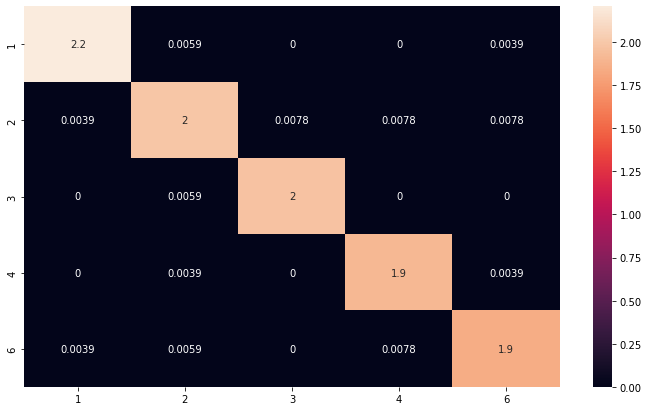

In [13]:
# The code above was for testing and find the best parameters

# For training the model you only need the code down below

nnloss = torch.nn.CrossEntropyLoss()
batchsize = 2048
num_workers = 2
train_loader, validation_loader, test_loader, total_train_loader = data_loader(batchsize,num_workers)

def best_train_net(net):
    params = list(filter(lambda p: p.requires_grad, net.parameters()))
    optimizer = optim.SGD(params, lr=0.1, momentum=0.9, weight_decay = 0, nesterov=True)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
    
    epochs = 100
    for epoch in range(epochs):
        net.train()
        for x, target in total_train_loader:
            if torch.cuda.is_available():
                x = x.cuda()[:]
                target = target.cuda().to(dtype=torch.long)
            optimizer.zero_grad()
            out = net(x)
            loss = nnloss(out, target)
            loss.backward()
            avg_train_loss.append(loss.item())
            optimizer.step()
        scheduler.step()
        train_loss = np.mean(avg_train_loss)
        if epoch % 10 == 0:
            print(f"\tepoch #{epoch} is finished.")
            print(f"\t  Avg. Train loss: {train_loss}")

print("Before optimizing the model")
print(f'Train Accuracy: {100 * calc_acc(train_loader,net):.2f}%')
best_train_net(net)
print("After optimizing the model")
findAccTrainTest(total_train_loader, test_loader, net)
confusion_matrix1()